In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mp_api.client import MPRester

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, auc, classification_report
)

from sklearn.svm import SVC
from xgboost import XGBClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


# 1. Get data from Material Project
API_KEY = "3G1tjXbFBpuI2ufJIr2pFkiOgqle24rU"

with MPRester(API_KEY) as mpr:
    thermo_docs = mpr.materials.thermo.search(chemsys="Mg-Si-O")  # Mg-Si-O 系统

data = []
for d in thermo_docs:
    data.append([
        d.material_id,
        d.formula_pretty,
        d.formation_energy_per_atom,
        d.energy_above_hull,
        getattr(d, "nsites", None),
        getattr(d, "volume", None),
        getattr(d, "density", None)
    ])

df_thermo = pd.DataFrame(data, columns=[
    "material_id",
    "formula_pretty",
    "formation_energy_per_atom",
    "energy_above_hull",
    "nsites",
    "volume",
    "density",
])


# 2. Data Pre-process
df_thermo.dropna(subset=[
    "formation_energy_per_atom",
    "energy_above_hull",
    "nsites",
    "volume",
    "density"
], inplace=True)

# Define Stability Label：energy_above_hull < 0.04 eV/atom equal to 0，else 1
df_thermo["stability_label"] = df_thermo["energy_above_hull"].apply(lambda x: 0 if x < 0.04 else 1)


print("Data Number:", len(df_thermo))
print(df_thermo.head(20))


# 3. Feature Extract
feature_cols = ["formation_energy_per_atom", "nsites", "volume", "density"]
X = df_thermo[feature_cols].values
y = df_thermo["stability_label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardized
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Retrieving ThermoDoc documents: 100%|████████████████████████████████████████████| 197/197 [00:00<00:00, 2113242.68it/s]

Data Number: 197
   material_id formula_pretty  formation_energy_per_atom  energy_above_hull  \
0   mp-1197475       Mg3Si2O9                  -2.330279           0.436090   
1   mp-1233493      Mg(SiO2)6                  -3.011621           0.161216   
2   mp-1221972         MgSiO4                  -2.367879           0.328272   
3   mp-1234904     Mg(SiO2)16                  -3.156427           0.074173   
4    mp-560321        Mg2SiO4                  -3.080698           0.141054   
5   mp-1233794      Mg(SiO2)5                  -2.946578           0.208568   
6   mp-1189710      Mg3Si4O13                  -2.702312           0.214301   
7   mp-1196569   Mg17(SiO3)20                  -3.075396           0.062873   
8   mp-1197410   Mg5(Si4O15)2                  -2.188988           0.375876   
9   mp-1203808   Mg17(SiO3)20                  -2.948396           0.189872   
10  mp-1210834     Mg7(SiO3)8                  -3.099460           0.055409   
11  mp-1211034      Mg2Si4O11      

[SVM] Accuracy = 0.925
[XGBoost] Accuracy = 0.975


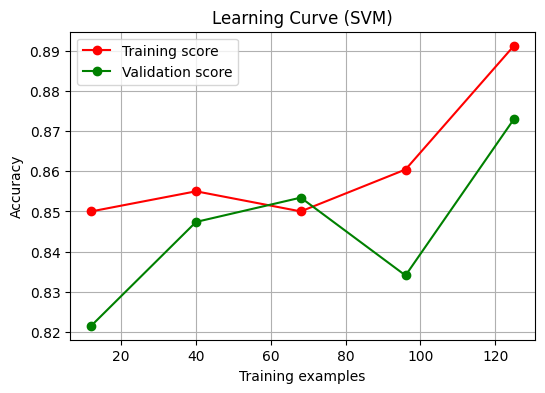

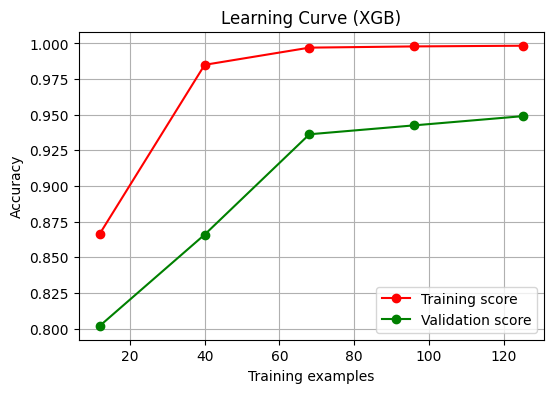

In [2]:
# 4. Model Training

########## 4.1 SVM ##########
svc_clf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42, probability=True)
svc_clf.fit(X_train_scaled, y_train)
y_pred_svc = svc_clf.predict(X_test_scaled)
svc_acc = accuracy_score(y_test, y_pred_svc)
print(f"[SVM] Accuracy = {svc_acc:.3f}")

########## 4.2 XGBoost ##########
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)
xgb_clf.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_clf.predict(X_test_scaled)
xgb_acc = accuracy_score(y_test, y_pred_xgb)
print(f"[XGBoost] Accuracy = {xgb_acc:.3f}")


#  Learning Curve (SVM & XGB) 
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring="accuracy", 
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
    )
    train_means = np.mean(train_scores, axis=1)
    val_means = np.mean(val_scores, axis=1)

    plt.figure(figsize=(6,4))
    plt.plot(train_sizes, train_means, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_means, 'o-', color="g", label="Validation score")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

plot_learning_curve(svc_clf, X_train_scaled, y_train, title="Learning Curve (SVM)")
plot_learning_curve(xgb_clf, X_train_scaled, y_train, title="Learning Curve (XGB)")


Epoch 1/50, Training Loss: 0.6592, Validation Loss: 0.6489
Epoch 2/50, Training Loss: 0.5928, Validation Loss: 0.6056
Epoch 3/50, Training Loss: 0.5286, Validation Loss: 0.5725
Epoch 4/50, Training Loss: 0.4642, Validation Loss: 0.5537
Epoch 5/50, Training Loss: 0.4165, Validation Loss: 0.5449
Epoch 6/50, Training Loss: 0.3887, Validation Loss: 0.5364
Epoch 7/50, Training Loss: 0.3829, Validation Loss: 0.5216
Epoch 8/50, Training Loss: 0.3855, Validation Loss: 0.4902
Epoch 9/50, Training Loss: 0.3478, Validation Loss: 0.4480
Epoch 10/50, Training Loss: 0.3541, Validation Loss: 0.4170
Epoch 11/50, Training Loss: 0.3153, Validation Loss: 0.4015
Epoch 12/50, Training Loss: 0.3101, Validation Loss: 0.3880
Epoch 13/50, Training Loss: 0.3166, Validation Loss: 0.3730
Epoch 14/50, Training Loss: 0.3105, Validation Loss: 0.3590
Epoch 15/50, Training Loss: 0.2897, Validation Loss: 0.3448
Epoch 16/50, Training Loss: 0.2859, Validation Loss: 0.3316
Epoch 17/50, Training Loss: 0.2745, Validation Lo

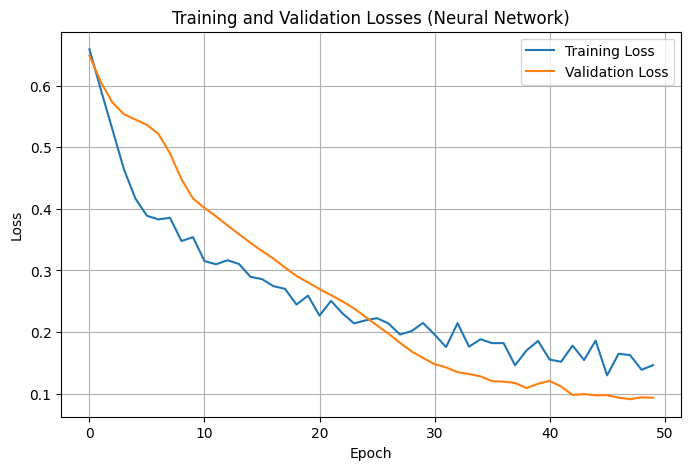

[Neural Network] Test Accuracy = 92.50%


In [3]:
# 5. PyTorch Neural Network
class EnhancedMLP(nn.Module):
    def __init__(self, input_dim):
        super(EnhancedMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(32, 2)  
        
    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x


X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

train_data = TensorDataset(X_train_torch, y_train_torch)
test_data  = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

model = EnhancedMLP(input_dim=len(feature_cols))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=50):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        avg_train_loss = running_train_loss / len(train_loader)
        
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        avg_val_loss = running_val_loss / len(test_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Training Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}")
    return train_losses, val_losses

train_losses, val_losses = train_and_validate(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=50
)

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses (Neural Network)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)


def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100.0 * correct / total
    print(f"[Neural Network] Test Accuracy = {accuracy:.2f}%")
    return accuracy

nn_accuracy = evaluate_model(model, test_loader)



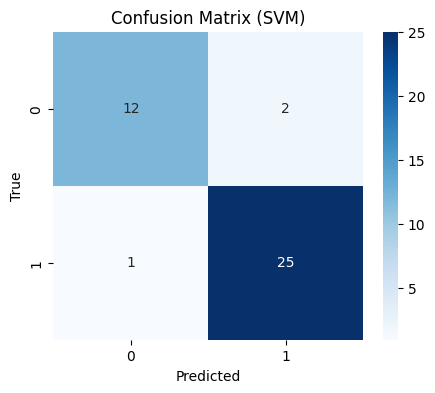

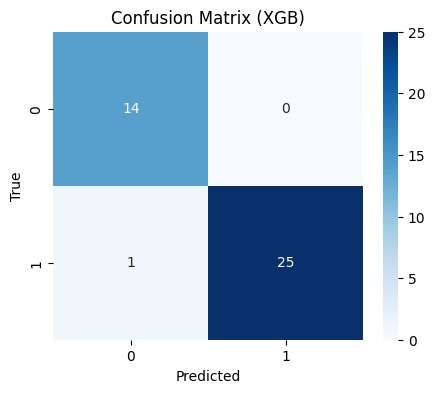

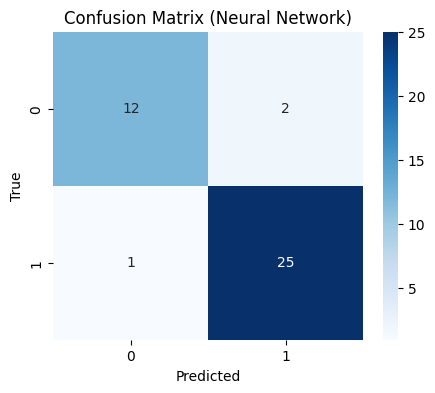

In [4]:
# 6. Evaluation

y_proba_svc = svc_clf.predict_proba(X_test_scaled)[:, 1]  # SVM
y_proba_xgb = xgb_clf.predict_proba(X_test_scaled)[:, 1]  # XGB

# NN
model.eval()
with torch.no_grad():
    outputs_nn = model(torch.tensor(X_test_scaled, dtype=torch.float32))
    nn_probs = torch.softmax(outputs_nn, dim=1)[:,1].numpy()

# 6.2 Confusion Matrix
def plot_confusion_matrix(labels, preds, title="Confusion Matrix"):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# 6.2.1 SVM 
plot_confusion_matrix(y_test, y_pred_svc, title="Confusion Matrix (SVM)")

# 6.2.2 XGB 
plot_confusion_matrix(y_test, y_pred_xgb, title="Confusion Matrix (XGB)")

# 6.2.3 NN 
nn_pred_labels = (nn_probs >= 0.5).astype(int)
plot_confusion_matrix(y_test, nn_pred_labels, title="Confusion Matrix (Neural Network)")



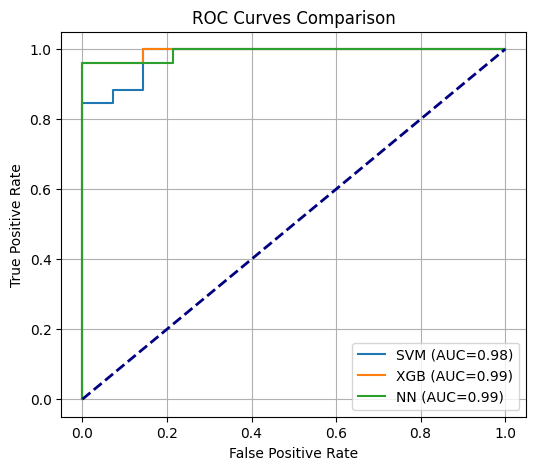

=== Classification Report (Macro Avg) ===
                 SVM        XGB         NN
precision   0.924501   0.966667   0.924501
recall      0.909341   0.980769   0.909341
f1-score    0.916143   0.972955   0.916143
support    40.000000  40.000000  40.000000
[SVM] Accuracy = 0.925
[XGBoost] Accuracy = 0.975
[Neural Network] Accuracy = 0.925


In [5]:
# 6.3 ROC Curve
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_proba_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_probs)
roc_auc_nn = auc(fpr_nn, tpr_nn)

plt.figure(figsize=(6,5))
plt.plot(fpr_svc, tpr_svc, label=f"SVM (AUC={roc_auc_svc:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB (AUC={roc_auc_xgb:.2f})")
plt.plot(fpr_nn, tpr_nn, label=f"NN (AUC={roc_auc_nn:.2f})")
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.grid(True)
plt.show()


report_svc = classification_report(y_test, y_pred_svc, output_dict=True)
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)
report_nn  = classification_report(y_test, nn_pred_labels, output_dict=True)

df_reports = pd.DataFrame({
    'SVM': pd.Series(report_svc['macro avg']),
    'XGB': pd.Series(report_xgb['macro avg']),
    'NN': pd.Series(report_nn['macro avg'])
})
print("=== Classification Report (Macro Avg) ===")
print(df_reports)


print(f"[SVM] Accuracy = {svc_acc:.3f}")
print(f"[XGBoost] Accuracy = {xgb_acc:.3f}")
print(f"[Neural Network] Accuracy = {nn_accuracy/100:.3f}")

/tmp/ipykernel_27154/3480146315.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_thermo[feature_cols].hist(bins=15, layout=(1, 4), ax=plt.gca())


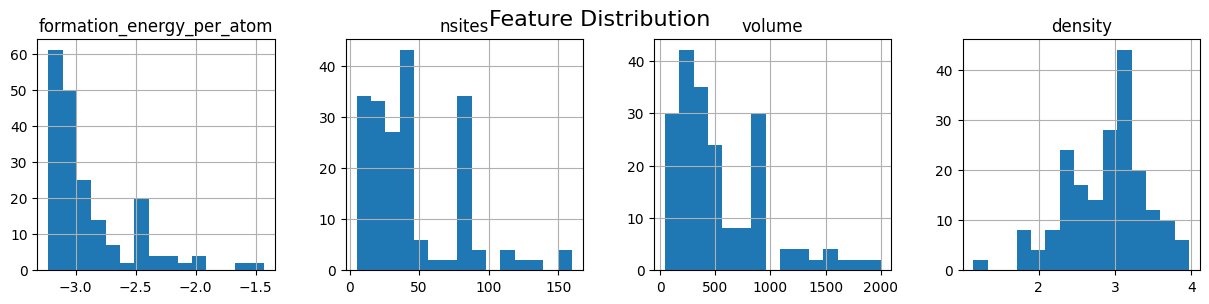

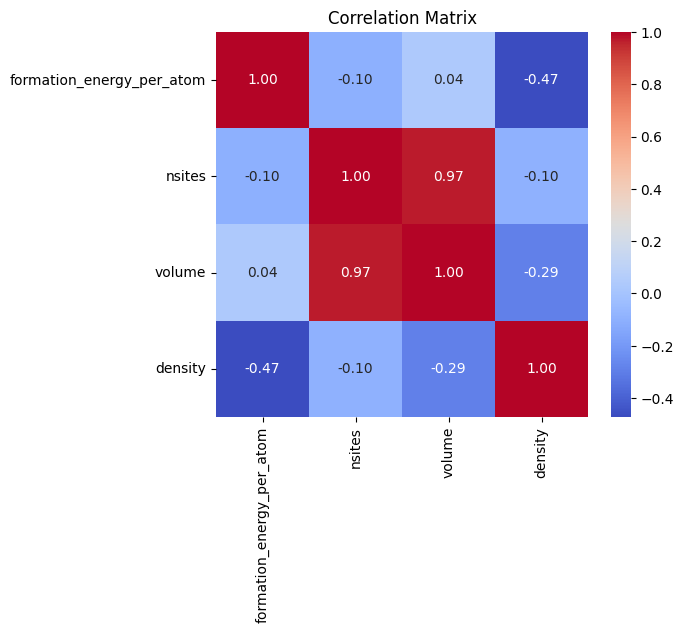

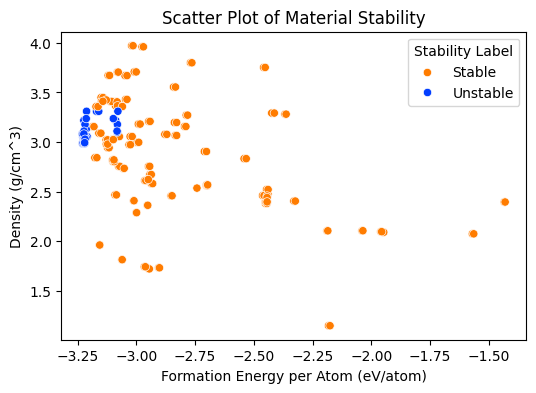

In [6]:
# 8.1 Feature Distribution
plt.figure(figsize=(15, 3))
df_thermo[feature_cols].hist(bins=15, layout=(1, 4), ax=plt.gca())  
plt.suptitle('Feature Distribution', fontsize=16)
plt.show()

# 8.2 Correlation Matrix
corr = df_thermo[feature_cols].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# 8.3 Scattering (formation_energy_per_atom vs density)
plt.figure(figsize=(6, 4))
sns.scatterplot(
    x='formation_energy_per_atom',
    y='density',
    hue='stability_label',
    data=df_thermo,
    palette='bright'
)
plt.title('Scatter Plot of Material Stability')
plt.xlabel('Formation Energy per Atom (eV/atom)')
plt.ylabel('Density (g/cm^3)')
plt.legend(title='Stability Label', labels=['Stable', 'Unstable'])
plt.show()

